In [1]:
import pybamm
import matplotlib.pyplot as plt

Set up a DFN model with a constant SEI film thickness, and make some of the parameters "input parameters" so that we can easily vary them and see the effect on the solution

In [2]:
model = pybamm.lithium_ion.DFN({"sei": "constant", "sei film resistance": "average"})

# Define "negative electrode resistance" and "positive electrode resistance"

param = model.param
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)

# Update parameters to easily vary eSOH parameters and current
x0 = pybamm.InputParameter("x0")
y0 = pybamm.InputParameter("y0")
Cn = pybamm.InputParameter("Cn")
Cp = pybamm.InputParameter("Cp")
L_sei = pybamm.InputParameter("L_sei")
Crate_charge = pybamm.InputParameter("Crate_charge")

# Need some transformations to convert these parameters into the DFN parameters
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
eps_over_C_n = parameter_values.evaluate(1/(param.F * param.A_cc * param.L_n * c_n_max / 3600))
eps_over_C_p = parameter_values.evaluate(1/(param.F * param.A_cc * param.L_p * c_p_max / 3600))

# Record initial values
C = parameter_values["Nominal cell capacity [A.h]"]
x0_init = parameter_values["Initial concentration in negative electrode [mol.m-3]"] / c_n_max
y0_init = parameter_values["Initial concentration in positive electrode [mol.m-3]"] / c_p_max
C_n_init = parameter_values["Negative electrode active material volume fraction"] / eps_over_C_n
C_p_init = parameter_values["Positive electrode active material volume fraction"] / eps_over_C_p
# In general SEI models have an "inner" and "outer" SEI
# Here we set the inner to 0 and just use the outer
L_sei_init = parameter_values["Initial inner SEI thickness [m]"] + parameter_values["Initial outer SEI thickness [m]"]

# Update parameter values, now the input parameters will need to be specified when solving
parameter_values.update({
    "Initial concentration in negative electrode [mol.m-3]": x0 * c_n_max,
    "Initial concentration in positive electrode [mol.m-3]": y0 * c_p_max,
    "Negative electrode active material volume fraction": Cn * eps_over_C_n,
    "Positive electrode active material volume fraction": Cp * eps_over_C_p,
    "Initial inner SEI thickness [m]": 0,
    "Initial outer SEI thickness [m]": L_sei,
    "Current function [A]": -Crate_charge * C, # negative for charge
})

print("x0_init = ", x0_init)
print("y0_init = ", y0_init)
print("C_n_init = ", C_n_init)
print("C_p_init = ", C_p_init)
print("L_sei_init = ", L_sei_init)
print("C = ", C)

x0_init =  0.0017000000000000001
y0_init =  0.8907009609949124
C_n_init =  5.973262521249683
C_p_init =  5.7956920121966125
L_sei_init =  5e-09
C =  5.0


Solve the simulation with the default values for all the parameters and plot the resistance

In [3]:
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sol = sim.solve([0,3600], inputs={
    "x0": x0_init, "y0": y0_init, "Cn": C_n_init, "Cp": C_p_init, "L_sei": L_sei_init, "Crate_charge": 1
})

Text(0, 0.5, 'Resistance [mOhm]')

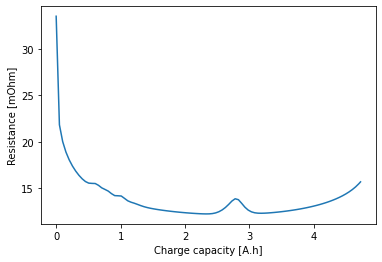

In [4]:
fig, axes = plt.subplots()

axes.plot(abs(sol["Discharge capacity [A.h]"].data), 
          abs(sol["Local ECM resistance [Ohm]"].data * 1e3))
axes.set_xlabel("Charge capacity [A.h]")
axes.set_ylabel("Resistance [mOhm]")

Solve again with a changed parameter

Text(0, 0.5, 'Resistance [mOhm]')

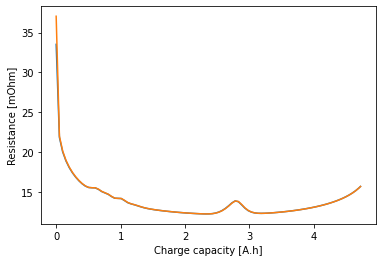

In [5]:
sol2 = sim.solve([0,3600], inputs={
    "x0": x0_init / 2, "y0": y0_init, "Cn": C_n_init, "Cp": C_p_init, "L_sei": L_sei_init, "Crate_charge": 1
})

fig, axes = plt.subplots()
axes.plot(abs(sol["Discharge capacity [A.h]"].data), 
          abs(sol["Local ECM resistance [Ohm]"].data * 1e3))
axes.plot(abs(sol2["Discharge capacity [A.h]"].data), 
          abs(sol2["Local ECM resistance [Ohm]"].data * 1e3))
axes.set_xlabel("Charge capacity [A.h]")
axes.set_ylabel("Resistance [mOhm]")

Now it is possile to plot different things: differences, other resistances, etc. Some variables that might be of interest are:

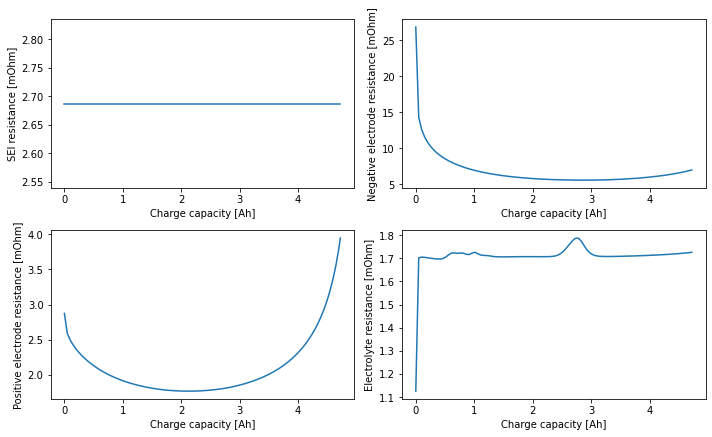

In [6]:
fig, axes = plt.subplots(2,2, figsize=(10,6))

variables = [
    ("SEI resistance [mOhm]", "X-averaged sei film overpotential [V]"),
    ("Negative electrode resistance [mOhm]", "X-averaged negative electrode reaction overpotential [V]"),
    ("Positive electrode resistance [mOhm]", "X-averaged positive electrode reaction overpotential [V]"),
    ("Electrolyte resistance [mOhm]", "X-averaged electrolyte overpotential [V]")
]



for k, (name, var) in enumerate(variables):
    ax = axes.flat[k]
    ax.plot(abs(sol["Discharge capacity [A.h]"].data), abs(sol[var].data / sol["Current [A]"].data) * 1e3)
    ax.set_xlabel("Charge capacity [Ah]")
    ax.set_ylabel(name)
    
fig.tight_layout()